In [1]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import sklearn.metrics
from tensorflow.keras.utils import plot_model

# Some methods and data which will be used below

In [2]:
# (i).   Mapping labels to their resp. classes
# (ii).  Mapping classes to their resp. labels

label_to_class = {
    1  : 'WALKING',          
    2  : 'WALKING_UPSTAIRS', 
    3  : 'WALKING_DOWNSTAIRS',
    4  : 'SITTING',      
    5  : 'STANDING',       
    6  : 'LAYING',         
    7  : 'STAND_TO_SIT',      
    8  : 'SIT_TO_STAND',     
    9  : 'SIT_TO_LIE',     
    10 : 'LIE_TO_SIT',      
    11 : 'STAND_TO_LIE',      
    12 : 'LIE_TO_STAND',   
    np.nan : np.nan
}
class_to_label = {
    'WALKING' : 1,
    'WALKING_UPSTAIRS' : 2,
    'WALKING_DOWNSTAIRS' : 3,
    'SITTING' : 4,
    'STANDING' : 5,         
    'LAYING' : 6,      
    'STAND_TO_SIT' : 7,     
    'SIT_TO_STAND' : 8,     
    'SIT_TO_LIE' : 9,     
    'LIE_TO_SIT' : 10,        
    'STAND_TO_LIE' : 11,     
    'LIE_TO_STAND' : 12,
    np.nan : np.nan
}

In [3]:
# Function to draw bar graph of classes corresponding to their frequencies in occurence

def draw_bar(ydata):
    print('Frequencies :- ',ydata.sum(axis = 0))
    
    x = np.arange(1,len(ydata[0])+1,1);
    y = ydata.sum(axis = 0)
    
    plt.figure(figsize = (12.8,3))
    plt.xlabel('Class Label',fontdict = {'size' : 15})
    plt.ylabel('Frequency',fontdict = {'size' : 15})
    bar = plt.bar(x,y)
    
    for idx,rect in enumerate(bar):
        plt.text(
            rect.get_x()+rect.get_width()/2.0,
            rect.get_height(),int(y[idx]),
            ha = 'center',
            va = 'bottom'
        )
        
    plt.show()

In [4]:
# Function to draw xtrain time_series sensor data for first  instance of activity_label(class)
# x == [ 0th milisecond data , 20th ms data , 40th ms, ...] for 50 Hz rate i.e. 20 ms for each timestamp 
# length = window_size
# row stores the index of first data_point that belongs to class == activity_label 

def draw_wave(xdata,ydata,activity_label):
    
    row = 0
    while(ydata[row].argmax()+1 != activity_label) : row = row + 1;
    
    length   = xdata.shape[1]
    sensor   = xdata.shape[2]
    channel  = xdata.shape[3]
    
    x = np.linspace(0,(20)*(length-1)/1000,length)
    
    plt.figure(figsize = (12.8,2))
    plt.plot(x,xdata[row,:,0,0])
    plt.plot(x,xdata[row,:,0,1])
    plt.plot(x,xdata[row,:,0,2])
    plt.show()
    
    plt.figure(figsize = (12.8,2))
    plt.plot(x,xdata[row,:,1,0])
    plt.plot(x,xdata[row,:,1,1])
    plt.plot(x,xdata[row,:,1,2])
    plt.xlabel('Time in seconds :- ( Instance of ' + label_to_class[activity_label] + ' data )',fontdict = {'size' : 15})
    plt.show()
    

In [5]:
# (i).   Removing data-points where y and x values is null

# Other methods can be
# ffill (forward fill) => fills using forward points
# bfill (backward fill) => using backward points
# interpolate

def remove_null(xdata,ydata):
    xdata = xdata[np.where(np.isfinite(ydata))]
    ydata = ydata[np.where(np.isfinite(ydata))]
    ydata = ydata[np.where(np.isfinite(xdata).all(axis = 1).all(axis = 1).all(axis = 1))]
    xdata = xdata[np.where(np.isfinite(xdata).all(axis = 1).all(axis = 1).all(axis = 1))]
 
    return xdata,ydata

In [6]:
# normalize xdata using sklearn.preprocessing.StandardScaler and returns 
# scaler object to use it furthur for testing data

# Each axis of each sensor has different min, max, I scaled according to them seperately
# Initial shape == (None,128,2,3)
# changed to (None , 6) :-
# reshape to (None,128,6) -> swapaxis(0,2) -> reshape(6,-1) -> transpose
# Fit scaler OR transform according to scaler

# Reverse above process to get back oiginal data
# transpose -> reshape(6,128,None) -> swapaxes(0,2) -> reshape(None,128,2,3)

def get_scaler(xdata):
    
    row = xdata.shape[0]
    timestamp = xdata.shape[1]
    sensor = xdata.shape[2]
    axis = xdata.shape[3]
    
    scaler = MinMaxScaler(feature_range = (-1,1))
    xdata = xdata.reshape(row,timestamp,sensor*axis)
    xdata = np.swapaxes(xdata,0,2).reshape(sensor*axis,-1).T
    scaler.fit(xdata)
    return scaler

def scale_data(xdata,scaler):
    
    row = xdata.shape[0]
    timestamp = xdata.shape[1]
    sensor = xdata.shape[2]
    axis = xdata.shape[3]
    
    xdata = xdata.reshape(row,timestamp,sensor*axis)
    xdata = np.swapaxes(xdata,0,2).reshape(sensor*axis,-1).T
    xdata = scaler.transform(xdata)
    xdata = xdata.T.reshape(sensor*axis,timestamp,row)
    xdata = np.swapaxes(xdata,0,2).reshape(row,timestamp,sensor,axis)
    
    return xdata

In [7]:
# takes in location, exp no., user no., start and end(end point is excluded from reading i.e lastpoint+1) point 
# ,overlap array, and returns xdata and ydata

def create_windows(location, exp, user, start, end, activity, length, overlap):
    
    acc_file  = location + '/acc_exp'+ str(exp).zfill(2) + '_user' + str(user).zfill(2) + '.txt'
    gyro_file = location + '/gyro_exp'+ str(exp).zfill(2) + '_user' + str(user).zfill(2) + '.txt'

    acc_data  = np.loadtxt(acc_file)
    gyro_data = np.loadtxt(gyro_file)
    
    xtrain = []
    ytrain = []
    
    while (start + length <= end) : 
          
        stop = start + length
        window = []
        
        while start != stop :
            window.append( [acc_data[start] , gyro_data[start]] )
            start += 1
        
        xtrain.append(window)
        ytrain.append(activity)
        
        start = stop - overlap[activity-1]

    return xtrain,ytrain

In [8]:
# location == location of file
# lenght == lenght of window
# overlap == array of overlaps of size == number of unique activities
# overlap depends on activity so as to extract more data from a particular class if needed


# (i).   Loading labels.txt as labels
# (ii).  Iterating in labels and calling create_windows on acceleration file, extending returned data in xtrain, ytrain 
# (iii). Iterating in labels and calling create_windows on gyroscope file, extending returned data in xtrain, ytrain 

def prepare_data(location,length = 128,overlap = [64]*12):

    xdata = []
    ydata = []
        
    labels = np.loadtxt(location+'/labels.txt',dtype = 'uint32')
    
    for exp,user,activity,start,end in labels :

        xtemp , ytemp = create_windows(location, exp, user, start, end+1, activity, length, overlap)
        xdata.extend(xtemp)
        ydata.extend(ytemp)
        
    return np.array(xdata),np.array(ydata)

In [9]:
# (i). Finds max element index sets its 1 and sets remaining 0
#      for each row

def to_categorical(ydata):
    
    for i in range(len(ydata)):
        j = ydata[i].argmax()
        for k in range(len(ydata[i])):
            ydata[i][k] = (k == j)
    return ydata

In [10]:
# (i).  OneHotEncoding ydata
# (ii). Converting sparsh matrix ydata into dense form and then matrix into numpy array

def one_hot_encoded(ydata):
    ydata = OneHotEncoder().fit_transform(ydata.reshape(len(ydata),1))
    ydata = np.asarray(ydata.todense())
    return ydata

# Data Preparation

## Loading data from files

In [11]:
# Preparing data, xtrain, ytrain
# Last six classes [7 to 12] has very less weightage in data since they are extra classes added 
# , made from original six classes
# so, I took more overlapping in them to get slightly more data

xtrain,ytrain = prepare_data('hapt-dataset/RawData',128,[64,64,64,64,64,64,120,120,120,120,120,120])

In [12]:
# Saving xdata and ydata temporarily for using again if needed

# with open('xdata','wb') as f:
#     pickle.dump(xtrain,f)
# with open('ydata','wb') as f:
#     pickle.dump(ytrain,f)

In [13]:
# To load temporarily saved prepared data

# with open('xdata','rb') as f:
#     xtrain = pickle.load(f)
# with open('ydata','rb') as f:
#     ytrain = pickle.load(f)

## Handling missing data and Normalizing data 

In [14]:
xtrain,ytrain = remove_null(xtrain,ytrain)

In [15]:
# splitting into training (70%) testing (15%) and validation (15%) set

xtrain,xtest,ytrain,ytest = train_test_split(xtrain,ytrain,test_size = 0.3)
xtest,xval,ytest,yval = train_test_split(xtest,ytest,test_size = 0.5)

In [16]:
xtrain.shape,ytrain.shape,xtest.shape,ytest.shape,xval.shape,yval.shape

((9355, 128, 2, 3),
 (9355,),
 (2005, 128, 2, 3),
 (2005,),
 (2005, 128, 2, 3),
 (2005,))

In [17]:
# (i).  Get scaler object
# (ii). Scaling xtrain and xtest

scaler = get_scaler(xtrain)
xtrain = scale_data(xtrain,scaler)
xtest  = scale_data(xtest,scaler)
xval   = scale_data(xval,scaler)

In [18]:
# One hot encoding y values

ytrain = one_hot_encoded(ytrain)
ytest = one_hot_encoded(ytest)
yval = one_hot_encoded(yval)

In [19]:
xtrain.shape,ytrain.shape,xtest.shape,ytest.shape,xval.shape,yval.shape

((9355, 128, 2, 3),
 (9355, 12),
 (2005, 128, 2, 3),
 (2005, 12),
 (2005, 128, 2, 3),
 (2005, 12))

### Visualizing distribution

For training data :- 
Frequencies :-  [1173. 1074.  973. 1286. 1360. 1402.  270.   75.  442.  342.  633.  325.]


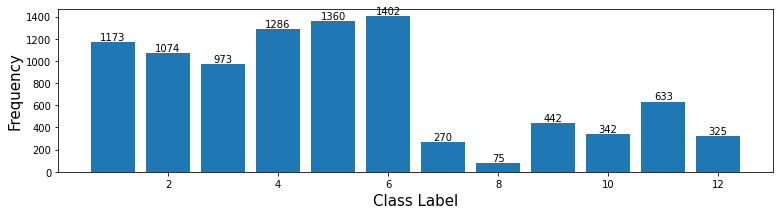

For testing data :- 
Frequencies :-  [272. 251. 214. 264. 306. 266.  50.  16.  89.  70. 136.  71.]


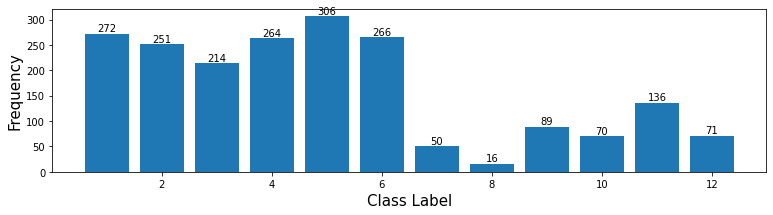

For validation data :- 
Frequencies :-  [277. 219. 220. 251. 313. 290.  55.  18.  97.  57. 142.  66.]


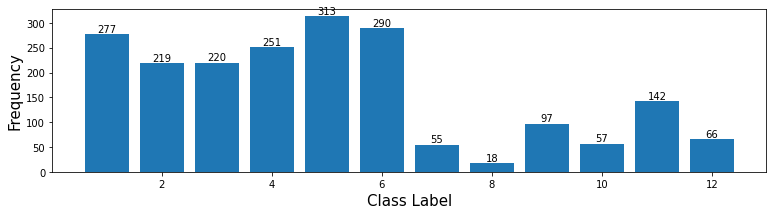

In [20]:
print('For training data :- ')
draw_bar(ytrain)
print('For testing data :- ')
draw_bar(ytest)
print('For validation data :- ')
draw_bar(yval)

## Visualizing sensors data for activities

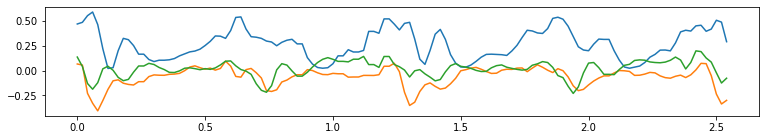

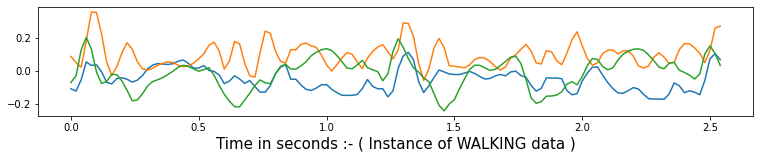

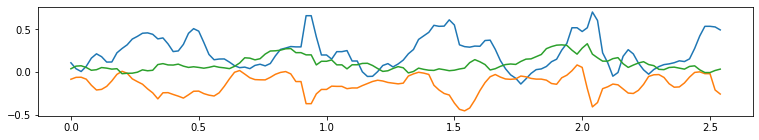

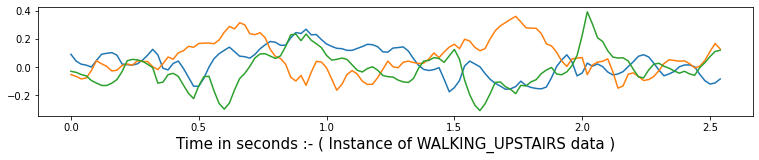

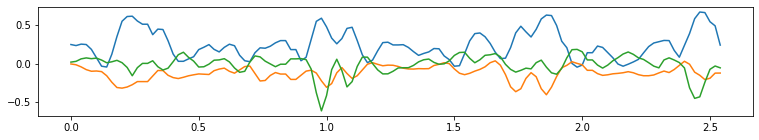

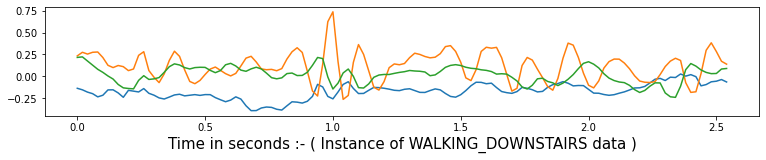

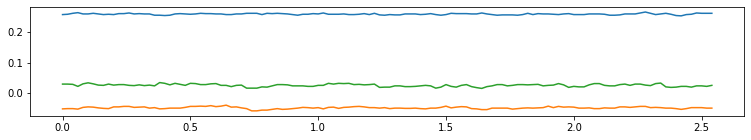

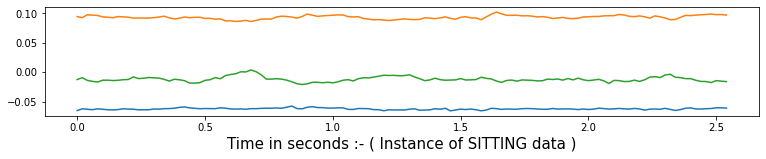

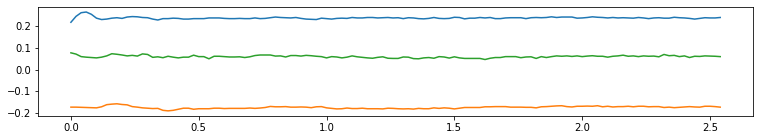

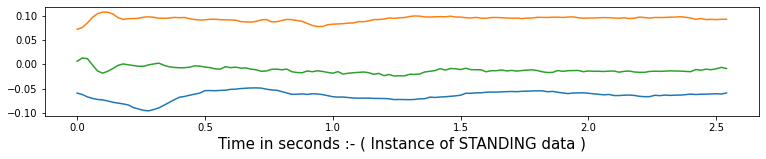

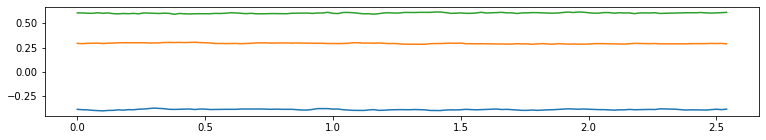

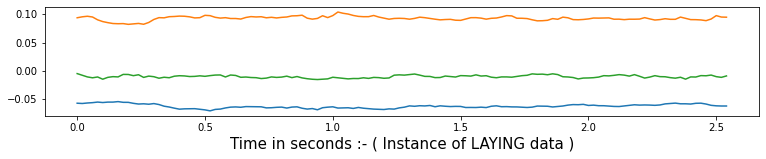

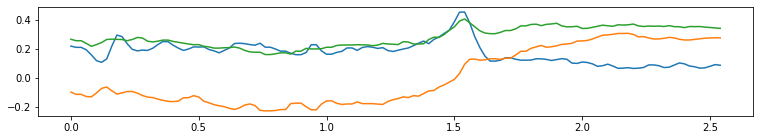

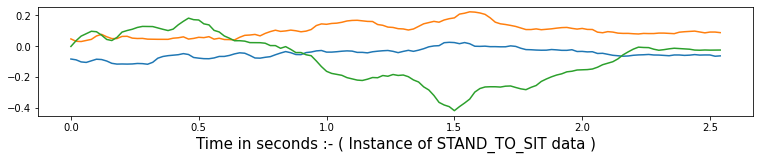

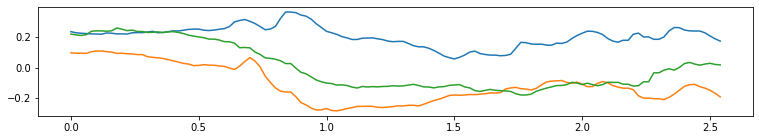

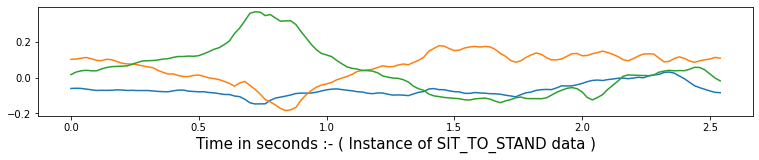

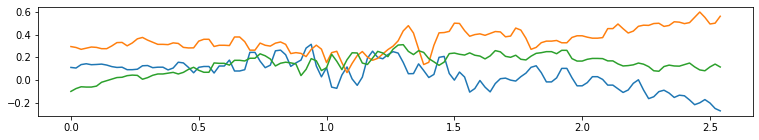

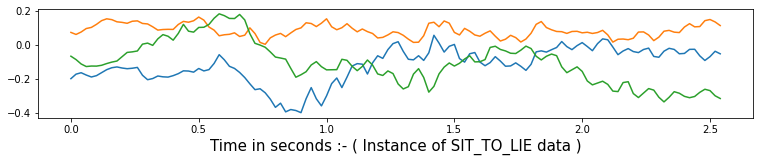

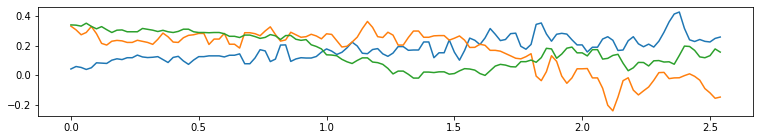

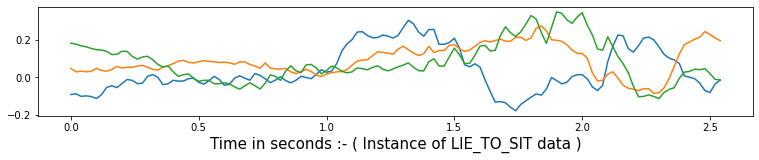

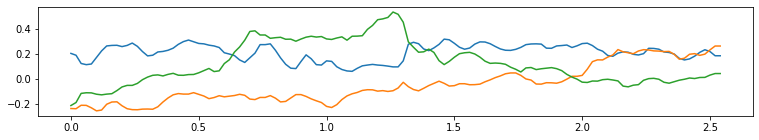

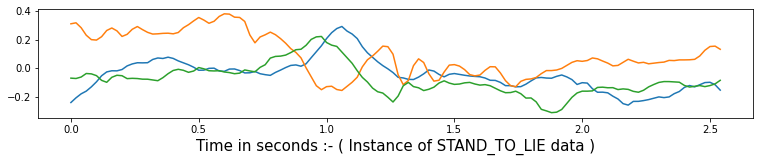

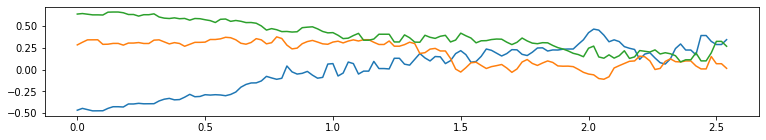

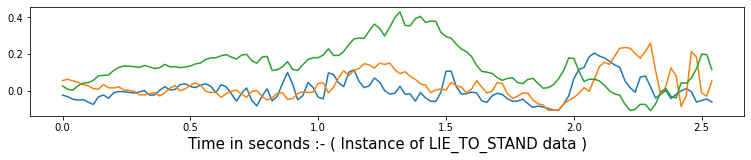

In [21]:
for i in range(12):
    draw_wave(xtrain,ytrain,i+1)    

# Building Model

In [22]:
#  input_shape == input_shape of each head (sensor data)
#  Here, input shape is of the form (128,3) for each head
#  seq == sequence no. of head 
#  no activations are applied after any layer ( => identity )

def cnnhead_(input_shape,seq):
    input_layer = keras.Input(shape = input_shape,name = 'title_'+str(seq))
    
    cnn = layers.Conv1D(24,2,1,"same",name = 'Conv1D_'+str(seq)+'_1')(input_layer)
    cnn = layers.LayerNormalization(name = 'layernorm_'+str(seq)+'_1')(cnn)
    cnn = layers.Dropout(rate = 0.5,name = 'dropout_'+str(seq)+'_1')(cnn)

    cnn = layers.Conv1D(48,2,1,"same",name = 'Conv1D_'+str(seq)+'_2')(cnn)
    cnn = layers.LayerNormalization(name = 'layernorm_'+str(seq)+'_2')(cnn)
    cnn = layers.Dropout(rate = 0.5,name = 'dropout_'+str(seq)+'_2')(cnn)
    
    cnn = layers.Conv1D(48,2,1,"same",name = 'Conv1D_'+str(seq)+'_3')(cnn)
    cnn = layers.LayerNormalization(name = 'layernorm_'+str(seq)+'_3')(cnn)

    return input_layer,cnn

In [23]:
# Concatenates last layer of each cnn head together in third dimension (channels)

def concatenate_(heads):
    final_layers = []
    for i,j in heads:
        final_layers.append(j)
    return layers.concatenate(final_layers,name = 'concatenate')

In [24]:
# builds last lstm block

def lstm_(input_, number_of_classes):
    x = layers.LSTM(4*number_of_classes,return_sequences = True,name = 'lstm_1')(input_)
    x = layers.LayerNormalization()(x)
    x = layers.LSTM(4*number_of_classes,return_sequences = True,name = 'lstm_2')(x)
    x = layers.LayerNormalization()(x)
    x = layers.LSTM(2*number_of_classes,name = 'lstm_3')(x)
    x = layers.LayerNormalization()(x)
    x = layers.Dense(2*number_of_classes,name = 'dense_1')(x)
    x = layers.Dense(number_of_classes,name = 'dense_2',activation = 'softmax')(x)
    return x

In [25]:
def model_(heads,dense_):
    return keras.Model([i for i,j in heads],dense_,name = 'model')

In [26]:
# xtrain is the form (row,window,sensor,axis)
# (None,128,2,3) here

def build_model( xtrain, ytrain ):
    heads = []
    
    shape = xtrain.shape
    
    for i in range(len(xtrain[0][0])):
        heads.append(cnnhead_((shape[1],shape[3]),i+1))
        
    x = concatenate_(heads)
    
    x = lstm_(x,ytrain.shape[1])

    model = model_(heads,x)
    
    return model

### Building up the model :- 

In [27]:
model = build_model(xtrain,ytrain)

2022-06-19 19:52:23.133638: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 19:52:23.219552: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 19:52:23.220285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 19:52:23.221328: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

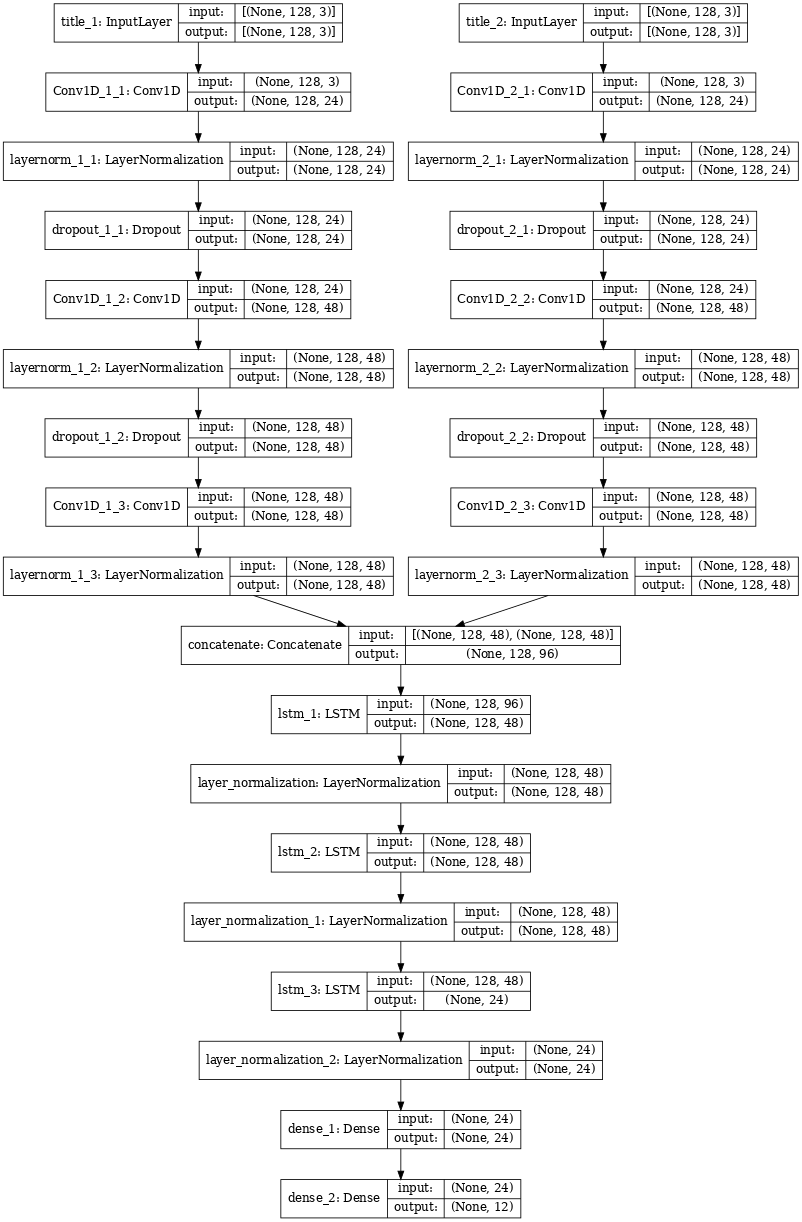

In [28]:
# install pydot
# install graphviz

plot_model(model, "multiheaded.png",show_shapes = True,dpi=60)

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_1 (InputLayer)            [(None, 128, 3)]     0                                            
__________________________________________________________________________________________________
title_2 (InputLayer)            [(None, 128, 3)]     0                                            
__________________________________________________________________________________________________
Conv1D_1_1 (Conv1D)             (None, 128, 24)      168         title_1[0][0]                    
__________________________________________________________________________________________________
Conv1D_2_1 (Conv1D)             (None, 128, 24)      168         title_2[0][0]                    
______________________________________________________________________________________________

# Finally, training :-

In [30]:
# These variables will be changed whenever needed

EPOCHS = 200
BATCH_SIZE = 100

In [31]:
import time

class progress_print(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs = None):
        self.start = time.time()
        
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch < 8 or (epoch+1)%10 == 0:
            print(
                'Epoch {}/{} - Time taken : {}s\nloss: {} - accuracy: {} - val_loss: {} - val_accuracy: {}\n'
                .format(epoch+1,EPOCHS,time.time()-self.start,logs['loss'],logs['accuracy'],logs['val_loss'],logs['val_accuracy'])
            )

In [32]:
# For 20 epochs

lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.001,
    decay_steps = int((xtrain.shape[0]+BATCH_SIZE)/BATCH_SIZE),
    decay_rate = 0.99
)


model.compile(loss = 'categorical_crossentropy',optimizer=keras.optimizers.Adam(learning_rate = lr_scheduler),metrics=['accuracy'])

history1 = model.fit(
    {'title_1':xtrain[:,:,0,:],'title_2':xtrain[:,:,1,:],
    },
    {'dense_2':ytrain},
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = (
        {'title_1':xval[:,:,0,:],'title_2':xval[:,:,1,:]},
        {'dense_2':yval}
    ),
    verbose = 0,
    callbacks = [progress_print()]
    #initial_epoch = 0
)

2022-06-19 19:52:27.507896: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-19 19:52:32.679826: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Epoch 1/200 - Time taken : 16.55651617050171s
loss: 1.2614527940750122 - accuracy: 0.5812934041023254 - val_loss: 0.804930567741394 - val_accuracy: 0.7157106995582581

Epoch 2/200 - Time taken : 2.70204496383667s
loss: 0.7036698460578918 - accuracy: 0.7516835927963257 - val_loss: 0.5683887600898743 - val_accuracy: 0.806483805179596

Epoch 3/200 - Time taken : 2.7332725524902344s
loss: 0.4970858097076416 - accuracy: 0.8125066757202148 - val_loss: 0.39580604434013367 - val_accuracy: 0.8513715863227844

Epoch 4/200 - Time taken : 2.748661994934082s
loss: 0.3699858486652374 - accuracy: 0.8533404469490051 - val_loss: 0.3366532027721405 - val_accuracy: 0.8738154768943787

Epoch 5/200 - Time taken : 2.7468905448913574s
loss: 0.3156779408454895 - accuracy: 0.8711918592453003 - val_loss: 0.28799277544021606 - val_accuracy: 0.8907730579376221

Epoch 6/200 - Time taken : 2.7361927032470703s
loss: 0.2859888970851898 - accuracy: 0.8898984789848328 - val_loss: 0.27735796570777893 - val_accuracy: 0.8

In [33]:
# For 100 epochs

model.compile(loss = 'categorical_crossentropy',optimizer=keras.optimizers.Adagrad(),metrics=['accuracy'])

EPOCHS += 100

history2 = model.fit(
    {'title_1':xtrain[:,:,0,:],'title_2':xtrain[:,:,1,:],
    },
    {'dense_2':ytrain},
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = (
        {'title_1':xval[:,:,0,:],'title_2':xval[:,:,1,:]},
        {'dense_2':yval}
    ),
    verbose = 0,
    callbacks = [progress_print()],
    initial_epoch = EPOCHS-100
)

Epoch 210/300 - Time taken : 2.8218934535980225s
loss: 0.0017167872283607721 - accuracy: 0.9994655251502991 - val_loss: 0.05732975900173187 - val_accuracy: 0.9875311851501465

Epoch 220/300 - Time taken : 2.7618753910064697s
loss: 0.0013217732775956392 - accuracy: 0.9994655251502991 - val_loss: 0.056818027049303055 - val_accuracy: 0.9865336418151855

Epoch 230/300 - Time taken : 2.8176939487457275s
loss: 0.0012108965311199427 - accuracy: 0.9996793270111084 - val_loss: 0.05742252245545387 - val_accuracy: 0.987032413482666

Epoch 240/300 - Time taken : 2.764112710952759s
loss: 0.0012230980210006237 - accuracy: 0.9996793270111084 - val_loss: 0.05733158811926842 - val_accuracy: 0.987032413482666

Epoch 250/300 - Time taken : 2.832622766494751s
loss: 0.0011357120238244534 - accuracy: 0.9996793270111084 - val_loss: 0.05742807313799858 - val_accuracy: 0.9875311851501465

Epoch 260/300 - Time taken : 2.766536235809326s
loss: 0.0011321495985612273 - accuracy: 0.9996793270111084 - val_loss: 0.05

#### Visualizing accuracy and losses

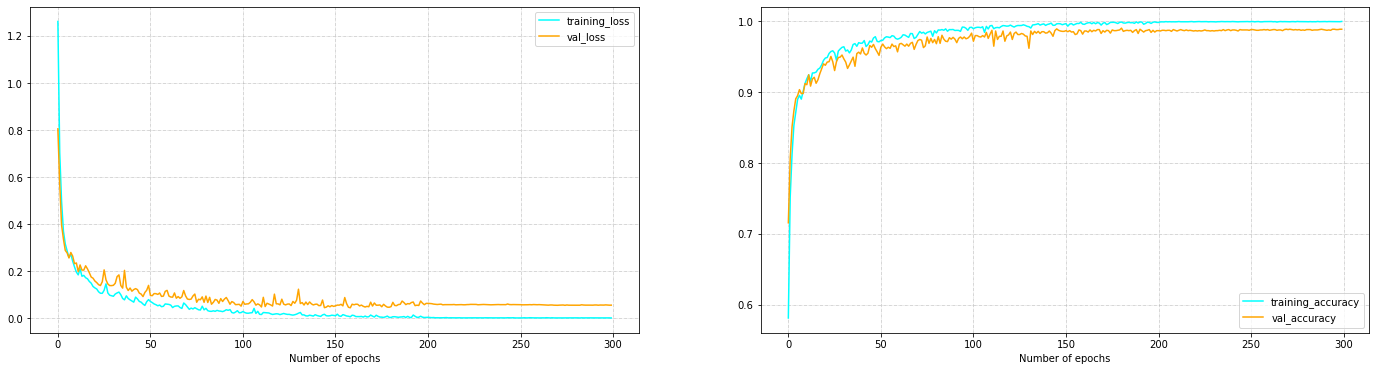

In [34]:
plt.figure(figsize = (24,6))

# Visualizing training_loss and val_loss

plt.subplot(1,2,1)
plt.xlabel('Number of epochs')
plt.grid(True,linewidth = '0.5',linestyle = '-.')
plt.plot(history1.history['loss']+history2.history['loss'],color = 'cyan')
plt.plot(history1.history['val_loss']+history2.history['val_loss'],color = 'orange')
plt.legend(['training_loss','val_loss'])

# Visualizing training_accuracy and val_accuracy

plt.subplot(1,2,2)
plt.xlabel('Number of epochs')
plt.grid(True,linewidth = '0.5',linestyle = '-.')
plt.plot(history1.history['accuracy']+history2.history['accuracy'],color = 'cyan')
plt.plot(history1.history['val_accuracy']+history2.history['val_accuracy'],color = 'orange')
plt.legend(['training_accuracy','val_accuracy'])

plt.show()

In [35]:
model.save_weights('trained_weights.h5')
model.load_weights('trained_weights.h5')

In [36]:
ytrain_pred = model.predict(
    {'title_1':xtrain[:,:,0,:],'title_2':xtrain[:,:,1,:],
    }
)
ytest_pred = model.predict(
    {'title_1':xtest[:,:,0,:],'title_2':xtest[:,:,1,:],
    }
)

In [37]:
# converts softmax ydata output into 0's and 1's

ytrain_pred = to_categorical(ytrain_pred)
ytest_pred = to_categorical(ytest_pred)

In [38]:
train_cm = confusion_matrix(ytrain.argmax(axis = 1),ytrain_pred.argmax(axis = 1))
test_cm = confusion_matrix(ytest.argmax(axis = 1),ytest_pred.argmax(axis = 1))

<AxesSubplot:>

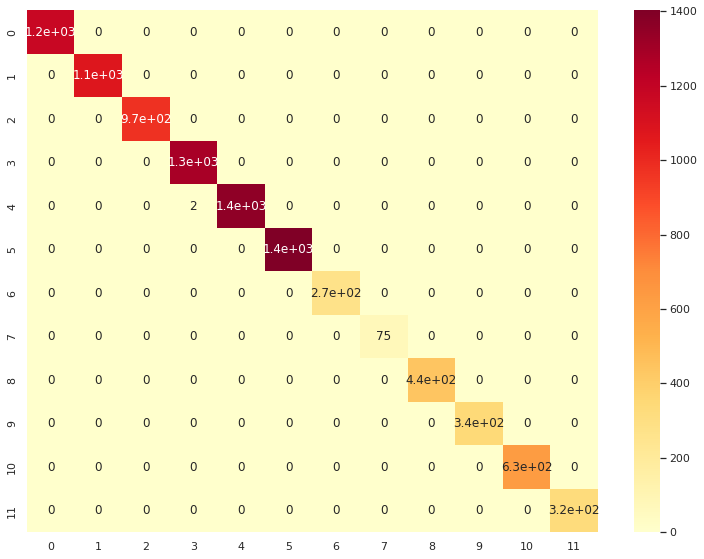

In [39]:
sb.set(rc = {'figure.figsize':(12.8,9.6)})
sb.heatmap(train_cm,annot = True,cmap = 'YlOrRd')

<AxesSubplot:>

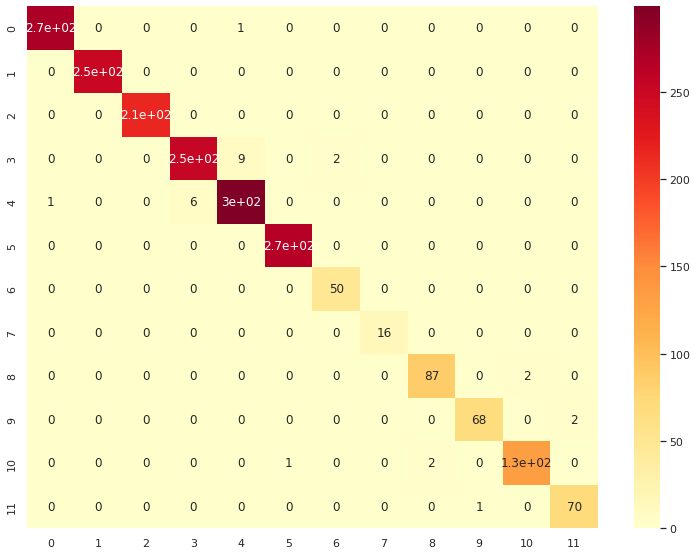

In [40]:
sb.set(rc = {'figure.figsize':(12.8,9.6)})
sb.heatmap(test_cm,annot = True, cmap = 'YlOrRd')

In [41]:
print(sklearn.metrics.classification_report(ytest.argmax(axis = 1),ytest_pred.argmax(axis = 1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       272
           1       1.00      1.00      1.00       251
           2       1.00      1.00      1.00       214
           3       0.98      0.96      0.97       264
           4       0.97      0.98      0.97       306
           5       1.00      1.00      1.00       266
           6       0.96      1.00      0.98        50
           7       1.00      1.00      1.00        16
           8       0.98      0.98      0.98        89
           9       0.99      0.97      0.98        70
          10       0.99      0.98      0.98       136
          11       0.97      0.99      0.98        71

    accuracy                           0.99      2005
   macro avg       0.98      0.99      0.99      2005
weighted avg       0.99      0.99      0.99      2005



### Saving model and scaler object (MinMaxScaler object)

In [42]:
model.save('saved_model/model')

2022-06-19 20:06:47.404578: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [43]:
with open('saved_model/scaler','wb') as f:
    pickle.dump(scaler,f)

In [44]:
# To load model and scaler

# model = keras.models.load_model('saved_Model/model')

# with open('saved_model/scaler','rb') as f:
#     scaler = pickle.load(f)

# ---------------------------------------------------------------------------------------------------------------

# ---------------------------------------------------------------------------------------------------------------